In this notebook, I will be presenting an approach for instance segmentation of overlapping filamentous objects. In particular, we will be working on the [BBBC010 dataset](https://bbbc.broadinstitute.org/BBBC010), that contains images of the roundworm *C. elegans*. Instance segmentation is commonly approached using region proposal approaches. These type approaches struggle to be performant for filamentous objects. In the presence of multiple similiar and overlapping instances, it is hard for these approaches to confidently identify the exact region boundaries and the commonly employed non-max suppression step will frequently suppress legit instances.

Here, I adapt the approach layed out by Hirsch et al.:
- [Hirsch et al. PatchPerPix for Instance Segmentation. **2020**](https://arxiv.org/pdf/2001.07626.pdf)

In this approach, first a semantic segmentation of the image is performed to classify pixels into three classes: "background", "foreground but only belonging to one instance", and "foreground but belonging to multiple instances". Then, for each pixel that belongs to the "foreground but only belonging to one instance" class, a binary mask of a smaller patch region around this pixel is predicted by feeding a code embeding coming from the previosly used network for semantic segmentation into a secondary decoder. All the predicted patches are then used to assemble instances.

Predicting all these patches is quite memory intensive. Therefore, we modify the approach by Hirsch et al. and so that patches can be predicted at a specified stride, which allows to lower the memory requirements. Secondly, we do not employ just a decoder to predict the patch mask from the code embeding. Instead, we use a second full-sized U-net and inject the code embedding at the bottom of this network. Furthermore, we will use a different strategy for patch assembly.




In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning
!pip install torch_geometric
!pip install httpimport

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00


In [3]:
import zipfile
import glob
from pathlib import Path
import random
from skimage import io
import matplotlib.pyplot as plt
import albumentations as A
from functools import partial

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import (
    Conv2d, ReLU, Sigmoid, BatchNorm2d, MaxPool2d, Upsample, Softmax, Linear, BatchNorm1d)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import logging
import pandas as pd
import pathlib
import cv2
import httpimport
with httpimport.github_repo("looooongChen", "sortedAP", ref="master"):
    import evaluation as evaluation

plt.rcParams["figure.dpi"] = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [4]:
probs_threshold = 0.5
affinity_zone = 0.85
affinity_threshold1 = -0.2
affinity_threshold2 = 0.1
min_agg_area = 100
stride = 1

# Unet
contractions_masks = 5
filter_init_masks = 14
contractions_patches = 4
filter_init_patches = 10
patch_size = 31
input_shape = (1, 520, 696)
resized_shape = (1, 256, 384)
codes = 16
f_hidden_size_conditional = 2

epochs = 125
patience_early_stopping = 30
batch_size = 1
accumulate_grad_batches = 8
loss_weights = [1, 2] # [masks, patches_masks]


# Learning rate scheduler
lr_after_warmup = 8e-4
lr_decay = 0.98
lr_max = lr_after_warmup * 3.5
lr_min = 5e-7
warmup_epochs = 4
f_reduction = 0.25
f_restart = 1.5
patience = 2
min_loss_improvement = 0.005
no_of_restarts_init = 2
increment_no_of_restarts = 1

I already have the dataset in my Google Drive:

In [5]:
with zipfile.ZipFile("./drive/MyDrive/BBBC010_v2_images.zip", "r") as f:
    f.extractall("./BBBC010_v2_images/")

with zipfile.ZipFile("./drive/MyDrive/BBBC010_v1_foreground_eachworm.zip", "r") as f:
    f.extractall("./")

We will be using the same train/validation/test split as in the original PatchPerPix paper. Let's have an intial look at an exemplary image and the associated semantic mask:

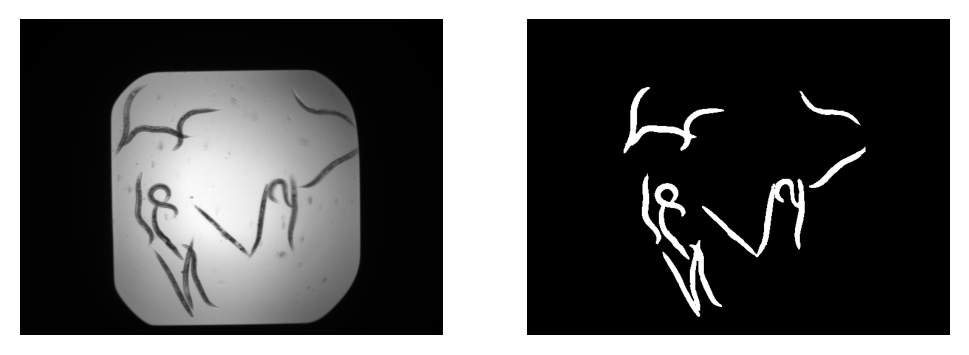

In [6]:
img_dir = "./BBBC010_v2_images/"
img_annotations = "./BBBC010_v1_foreground_eachworm/"

ids_train = [
    "A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10",
    "A11", "A12", "A13", "A14", "A15", "A16", "A19", "A20", "A21", "A23",
    "A24", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09",
    "B10", "B11", "B12", "B13", "B14", "B15", "B16", "B17", "B18", "B19",
    "B20", "B21", "B22", "B23", "B24", "C01", "C03", "C05", "C06", "C07",
    "C08", "C09", "C10", "C12", "C13", "C14", "C15", "C16", "C18", "C19",
    "C20", "C22", "C23", "C24", "E01", "E02", "E03", "E04"
    ]
ids_val = ["A17", "A18", "A22", "C02", "C04", "C11", "C17", "C21"]
ids_test = [
    "D01", "D02", "D03", "D04", "D05", "D06", "D07", "D08", "D09", "D10",
    "D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18", "D19", "D20",
    "D21", "D22", "D23", "D24"
    ]

fp_imgs_train = sorted([
    x for x in glob.glob(img_dir + "*.tif") if ("w2" in x) &
    (any(("_" + id_train + "_") in x for id_train in ids_train))])
fp_imgs_val = sorted([
    x for x in glob.glob(img_dir + "*.tif") if ("w2" in x) &
    (any(("_" + id_val + "_") in x for id_val in ids_val))])
fp_imgs_test = sorted([
    x for x in glob.glob(img_dir + "*.tif") if ("w2" in x) &
    (any(("_" + id_test + "_") in x for id_test in ids_test))])
fp_annotations = [Path(x) for x in glob.glob(img_annotations + "*.png")]


def retreive_img_and_annotations(fp_img, fp_annotations):
    cur_img_id = str(fp_img).split("_")[-3]
    img = np.expand_dims(io.imread(fp_img), 2)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))

    fp_masks_cur = [
        str(x) for x in fp_annotations if cur_img_id in str(x).split("/")[-1]]
    mask_instances = np.zeros(img.shape[0:2] + (len(fp_masks_cur), ))
    for idx, fp_mask_cur in enumerate(fp_masks_cur):
        mask_instances[:, :, idx] = io.imread(fp_mask_cur) / 255
    mask_semantic = np.max(mask_instances, axis=-1, keepdims=True)
    return img, mask_instances, mask_semantic


img0, mask_instances0, mask_semantic0 = retreive_img_and_annotations(
    fp_imgs_train[3], fp_annotations)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(img0, cmap="gray")
ax[1].imshow(mask_semantic0, cmap="gray")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

In [7]:
def zeropad_img(img, pad_width):
    c, h, w = img.shape
    img_padded = np.zeros(
        (c, h + 2 * pad_width, w + 2 * pad_width), dtype=img.dtype)
    img_padded[:, pad_width:-pad_width, pad_width:-pad_width] = img
    return img_padded


def get_mask_no_instances(mask_instances):
    mask_no_instances = np.count_nonzero(
        mask_instances, axis=-1)
    mask_no_instances = np.where(
        mask_no_instances > 1, 2, mask_no_instances)

    mask_no_instances = np.eye(3)[mask_no_instances] # one-hot encoding
    mask_no_instances = np.moveaxis(mask_no_instances, 2, 0)
    return mask_no_instances


def downsample(coords_x, coords_y, stride, patch_size=None):
    if patch_size is not None:
        coords_x = coords_x - math.floor(patch_size / 2)
        coords_y = coords_y - math.floor(patch_size / 2)

    remainder = np.mod(np.stack((coords_x, coords_y), axis=-1), stride)
    mask = np.equal(remainder, 0)
    coords_x = coords_x[np.all(mask, axis=-1)]
    coords_y = coords_y[np.all(mask, axis=-1)]

    if patch_size is not None:
        coords_x = coords_x + math.floor(patch_size / 2)
        coords_y = coords_y + math.floor(patch_size / 2)
    return coords_x, coords_y


def get_mask_patches(mask_instances, patch_size, stride):
    """
    """
    mask_no_instances = get_mask_no_instances(mask_instances)
    mask_no_instances_padded = zeropad_img(
        mask_no_instances, math.floor(patch_size / 2))
    mask_instances_padded = zeropad_img(
        np.moveaxis(mask_instances, 2, 0), math.floor(patch_size / 2))

    coords_x, coords_y = np.where(
        mask_no_instances_padded[1, :, :] == 1)
    coords_x, coords_y = downsample(coords_x, coords_y, stride, patch_size)
    coords_x_min = coords_x - math.floor(patch_size / 2)
    coords_y_min = coords_y - math.floor(patch_size / 2)
    coords_x_max = coords_x + math.ceil(patch_size / 2)
    coords_y_max = coords_y + math.ceil(patch_size / 2)
    coords_instance = np.argmax(
        mask_instances_padded[:, coords_x, coords_y], axis=0)

    mask_patches = np.zeros(
        (coords_instance.shape[0], 1, patch_size, patch_size))

    for idx, ((x_min, x_max), (y_min, y_max)) in enumerate(zip(
            zip(coords_x_min, coords_x_max), zip(coords_y_min, coords_y_max))):
        mask_patches[idx] = mask_instances_padded[
            coords_instance[idx], x_min:x_max, y_min:y_max]
    return mask_no_instances, mask_patches

Now we will create a Pytorch dataset that will return the image, the semantic mask (with classes "background", "foreground but only belonging to one instance", and "foreground but belonging to multiple instances") - and example of these two outputs is shown as the output of this cell - and the binary masks for the smaller patches (an exemplary extract of this will be shown as the output of the next cell):

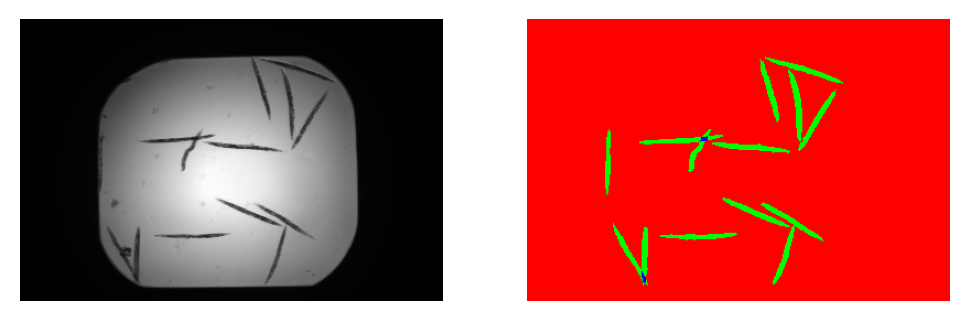

In [8]:
class CustomDataset(Dataset):
    def __init__(self, fp, fp_annotations, patch_size, stride, augment=False):
        self.fp = fp
        self.fp_annotations = fp_annotations
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment

    def get(self):
        pass

    def len(self):
        pass

    def __len__(self):
        return len(self.fp)

    def __getitem__(self, idx):
        img, mask_instances, mask_semantic = retreive_img_and_annotations(
            self.fp[idx], self.fp_annotations)

        if self.augment:
            transform = A.Compose([
                A.Resize(resized_shape[1], resized_shape[2]),
                A.HorizontalFlip(p=0.3),
                A.VerticalFlip(p=0.3),
                A.RandomGamma(gamma_limit=(70, 130), p=0.3),
                A.Rotate(limit=30, p=0.5),
                ], additional_targets={"mask1": "mask", "mask2": "mask"})
        else:
            transform = A.Compose([
                A.Resize(resized_shape[1], resized_shape[2]),
                ], additional_targets={"mask1": "mask", "mask2": "mask"})

        transformed = transform(
            image=img, mask1=mask_instances, mask2=mask_semantic)
        img = transformed["image"]
        mask_instances = transformed["mask1"]
        mask_semantic = transformed["mask2"]

        img = torch.moveaxis(torch.tensor(img).float(), 2, 0)
        mask_no_instances, mask_patches = get_mask_patches(
            mask_instances, self.patch_size, self.stride)

        mask_no_instances = torch.tensor(mask_no_instances).float()
        mask_patches = torch.tensor(mask_patches).float()
        return img, mask_no_instances, mask_patches


def custom_collate(batch):
    img = torch.stack([item[0] for item in batch])
    mask_no_instances = torch.stack([item[1] for item in batch])
    mask_patches = [item[2] for item in batch]
    return img, mask_no_instances, mask_patches


ds_train = CustomDataset(fp_imgs_train, fp_annotations, patch_size, stride, augment=True)
ds_val = CustomDataset(fp_imgs_val, fp_annotations, patch_size, stride)

loader_train = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
loader_val = DataLoader(
    ds_val, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

img0, mask_no_instances0, mask_patches0 = ds_val[0]

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(np.moveaxis(img0.numpy(), 0, 2), cmap="gray")
ax[1].imshow(np.moveaxis(mask_no_instances0.numpy(), 0, 2))
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

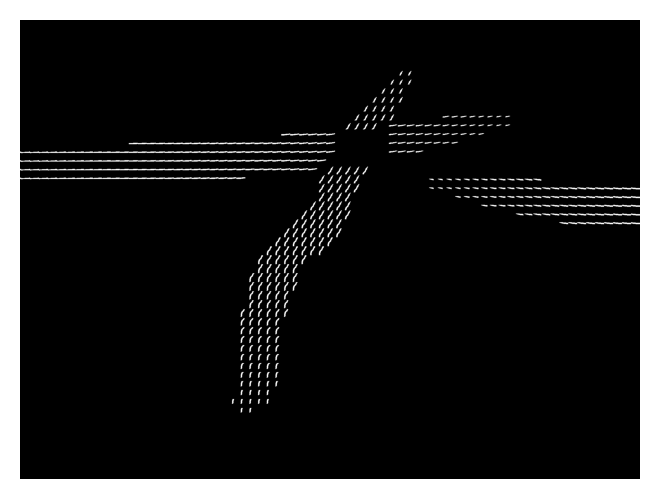

In [9]:
def display_img_of_patches(mask_no_instances, mask_patches, stride, xlim, ylim):
    patch_size = mask_patches.shape[2]
    coords_x, coords_y = np.where(
        mask_no_instances[1, :, :] == 1)
    coords_x, coords_y = downsample(coords_x, coords_y, stride, None)
    img_of_patches = np.zeros((mask_no_instances.shape[1] * patch_size,
                               mask_no_instances.shape[2] * patch_size))

    for idx, (coord_x, coord_y) in enumerate(zip(coords_x, coords_y)):
        img_of_patches[
            (coord_x * patch_size):(coord_x * patch_size + patch_size),
             (coord_y * patch_size):(coord_y * patch_size + patch_size)
             ] = mask_patches[idx]

    xlim = [int(xlim[0] * mask_no_instances.shape[1] * patch_size),
            int(xlim[1] * mask_no_instances.shape[1] * patch_size)]
    ylim = [int(ylim[0] * mask_no_instances.shape[2] * patch_size),
            int(ylim[1] * mask_no_instances.shape[2] * patch_size)]

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(
        img_of_patches[xlim[0]:xlim[1], ylim[0]:ylim[1]], cmap="gray")
    ax.set_axis_off()
    plt.show()


display_img_of_patches(
    mask_no_instances0, mask_patches0, stride, [0.37, 0.57], [0.32, 0.5])

In [10]:
class Conditional(nn.Module):
    def __init__(self, filters, input_shape, codes, f_hidden_size):
        super().__init__()
        self.filters = filters
        self.input_shape = input_shape
        self.linear1 = Linear(
            filters  * input_shape[0] * input_shape[1] + codes,
            filters  * input_shape[0] * input_shape[1] * f_hidden_size)
        self.linear2 = Linear(
            filters  * input_shape[0] * input_shape[1] * f_hidden_size,
            filters  * input_shape[0] * input_shape[1])
        self.layernorm1 = nn.LayerNorm(
            filters  * input_shape[0] * input_shape[1] + codes)
        self.layernorm2 = nn.LayerNorm(
            filters  * input_shape[0] * input_shape[1])

    def forward(self, x, codes):
        x_flat = torch.flatten(x, start_dim=1)
        codes = torch.flatten(codes, start_dim=1)
        z = torch.hstack((x_flat, codes))
        z = self.layernorm1(z)

        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        z = self.layernorm2(z)

        z = z.reshape((-1, int(self.filters), self.input_shape[0],
                       self.input_shape[1]))
        return z


class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out, contract=False,
                 downsample_size=None, expand=False, upsample_size=None,
                 codes=None, bottom_shape=None, f_hidden_size_conditional=None):
        super().__init__()
        self.conv1 = Conv2d(
            in_channels=filters_in, out_channels=filters_out,
            kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(
            in_channels=filters_out, out_channels=filters_out,
            kernel_size=3, stride=1, padding=1)
        self.activation = ReLU()
        self.bn1 = BatchNorm2d(filters_out)
        self.bn2 = BatchNorm2d(filters_out)

        self.contract = contract
        self.expand = expand
        self.downsample_size = downsample_size
        self.codes = codes

        if expand:
            if upsample_size is None:
                self.upsample = Upsample(scale_factor=2, mode="bilinear")
            else:
                self.upsample = Upsample(size=upsample_size, mode="bilinear")
        if contract:
            if downsample_size is None:
                self.pooling = MaxPool2d((2, 2))
        if codes is not None:
            self.conditional = Conditional(
                filters_out, input_shape=bottom_shape, codes=codes,
                f_hidden_size=f_hidden_size_conditional)

    def forward(self, x, x_skip=None, codes=None):
        if self.expand:
            x = self.upsample(x)
            if x_skip is not None:
                x = torch.cat([x, x_skip], dim=1)

        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)

        if self.codes is not None:
            x = self.conditional(x, codes=codes)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)

        if self.contract & (self.downsample_size is None):
            return self.pooling(x), x
        elif self.contract & (self.downsample_size is not None):
            return F.interpolate(x, self.downsample_size, mode="bilinear"), x
        else:
            return x


def calc_filter_sizes_for_unet(contractions, filter_init, input_shape, blocks):
    factors = [2**x for x in range(math.ceil(blocks / 2))]
    factors.extend(factors[::-1][1:])

    filters = []
    for idx in range(len(factors)):
        if idx == 0:
            filters.append([input_shape[0], filter_init*factors[idx]])
        elif idx in range(contractions+1):
            filters.append(
                    [filter_init*factors[idx-1], filter_init*factors[idx]])
        else:
            filters.append(
                [filter_init*factors[idx-1] + (filter_init*factors[idx-1]) // 2,
                 filter_init*factors[idx]])
    return filters


class MainUNet(nn.Module):
    def __init__(
        self, contractions, filter_init, input_shape, stride=None, codes=None):
        super().__init__()
        assert (math.log2(stride)+1 <= contractions), "Chose stride so that the codes_head branches off the expansion path"
        self.contractions = contractions
        self.blocks = contractions * 2 + 1
        self.stride = stride
        self.filters = calc_filter_sizes_for_unet(
            contractions, filter_init, input_shape, self.blocks)

        self.activation = ReLU()
        self.bn = BatchNorm2d(
            self.filters[-(int(math.log2(self.stride)) + 1)][1])
        self.codes = Conv2d(
            in_channels=self.filters[-(int(math.log2(self.stride)) + 1)][1],
            out_channels=codes, kernel_size=3, stride=1, padding=1)

        self.layers = nn.ModuleList()
        for idx, (f_in, f_out) in enumerate(self.filters):
            if idx in range(contractions):
                self.layers.append(UNetBlock(f_in, f_out, contract=True))
            elif idx == contractions:
                self.layers.append(UNetBlock(f_in, f_out))
            else:
                self.layers.append(UNetBlock(f_in, f_out, expand=True))
        self.final = Conv2d(
            in_channels=self.filters[-1][1], out_channels=3, kernel_size=3,
            stride=1, padding=1)
        self.softmax = Softmax(dim=1)

    def forward(self, x, codes=None):
        x_skips = []
        for idx, (_, _) in enumerate(self.filters):
            if idx in range(self.contractions):
                x, x_skip = self.layers[idx](x)
                x_skips.append(x_skip)
            elif idx == self.contractions:
                x = self.layers[idx](x)
            elif idx == (self.blocks - math.log2(self.stride) - 1):
                x = self.layers[idx](
                    x, x_skips[-(idx - math.floor(self.blocks/2))])
                codes_head = self.activation(self.codes(self.bn(x)))
            else:
                x = self.layers[idx](
                    x, x_skips[-(idx - math.floor(self.blocks/2))])
        x = self.softmax(self.final(x))
        return x, codes_head


class PatchesUNet(nn.Module):
    def __init__(self, contractions, filter_init, input_shape, codes,
                 f_hidden_size_conditional):
        super().__init__()
        self.contractions = contractions
        self.blocks = contractions * 2 + 1
        self.stride = stride
        self.filters = calc_filter_sizes_for_unet(
            contractions, filter_init, input_shape, self.blocks)

        if ((not math.log2(input_shape[1]).is_integer()) or
            (not math.log2(input_shape[2]).is_integer())):
            self.downsample_size_init = (
                2**math.floor(math.log2(input_shape[1])),
                2**math.floor(math.log2(input_shape[2])))
        else:
            self.downsample_size_init = None

        self.layers = nn.ModuleList()
        for idx, (f_in, f_out) in enumerate(self.filters):
            if (idx == 0) & (self.downsample_size_init is not None):
                self.layers.append(
                    UNetBlock(f_in, f_out, contract=True,
                              downsample_size=self.downsample_size_init))
            elif idx in range(contractions):
                self.layers.append(UNetBlock(f_in, f_out, contract=True))
            elif idx == contractions:
                bottom_shape = (
                    2**math.ceil(
                        math.log2(input_shape[1] / 2**contractions)), ) * 2
                self.layers.append(
                    UNetBlock(
                        f_in, f_out, codes=codes, bottom_shape=bottom_shape,
                        f_hidden_size_conditional=f_hidden_size_conditional))
            elif ((idx == (len(self.filters) - 1)) &
                  (self.downsample_size_init is not None)):
                self.layers.append(
                    UNetBlock(
                        f_in, f_out, expand=True, upsample_size=(
                            input_shape[1], input_shape[2])))
            else:
                self.layers.append(UNetBlock(f_in, f_out, expand=True))

        self.final = Conv2d(
            in_channels=filter_init, out_channels=1, kernel_size=3,
            stride=1, padding=1)
        self.sigmoid = Sigmoid()

    def forward(self, x, codes=None):
        x_skips = []
        for idx, (_, _) in enumerate(self.filters):
            if idx in range(self.contractions):
                x, x_skip = self.layers[idx](x)
                x_skips.append(x_skip)
            elif idx == self.contractions:
                x = self.layers[idx](x, codes=codes)
            else:
                x = self.layers[idx](
                    x, x_skips[-(idx - math.floor(self.blocks/2))])
        x = self.sigmoid(self.final(x))
        return x


class PatchPerPix(nn.Module):
    def __init__(
            self, contractions_masks, filter_init_masks, contractions_patches,
            filter_init_patches, input_shape, codes, patch_size, stride,
            f_hidden_size_conditional):
        super().__init__()
        self.patch_size = patch_size
        self.input_shape = input_shape
        self.stride = stride

        self.unet_masks = MainUNet(
            contractions_masks, filter_init_masks, input_shape, stride, codes)
        self.unet_patches = PatchesUNet(
            contractions_patches, filter_init_patches, (
                input_shape[0], patch_size, patch_size), codes,
            f_hidden_size_conditional)

    def forward(self, imgs, masks_true=None):
        masks_pred, codes = self.unet_masks(imgs)

        # Decoding of codes
        if masks_true is not None:
            masks = masks_true[:, 1, ::self.stride, ::self.stride]
        else:
            masks = (torch.argmax(masks_pred, axis=1) == 1).float()
            masks = masks[:, ::self.stride, ::self.stride]

        patches_imgs = []
        patches_codes = []
        patches_masks_pred = []

        imgs_padded = F.pad(
            imgs, (math.floor(self.patch_size / 2),) * 4, mode="constant")

        # Get image patches and codes of foreground pixels
        for idx1, mask in enumerate(masks):
            coords_fg_x, coords_fg_y = torch.where(mask == 1)

            patches_codes.append(
                torch.moveaxis(codes[idx1, :, coords_fg_x, coords_fg_y], 0, 1))

            patches_img = torch.zeros(
                (coords_fg_x.shape[0], self.input_shape[0], self.patch_size,
                 self.patch_size)).to(device) # XXX

            coords_fg_x_min = coords_fg_x
            coords_fg_y_min = coords_fg_y
            coords_fg_x_max = coords_fg_x + self.patch_size
            coords_fg_y_max = coords_fg_y + self.patch_size

            for idx2, ((x_min, x_max), (y_min, y_max)) in enumerate(zip(
                    zip(coords_fg_x_min, coords_fg_x_max),
                    zip(coords_fg_y_min, coords_fg_y_max))):
                patches_img[idx2, :, :, :] = imgs_padded[
                    idx1, :, x_min:x_max, y_min:y_max]
            patches_imgs.append(patches_img)

        # Pass image patches and codes into second Unet
        for (patches_img, codes_fg) in zip(patches_imgs, patches_codes):
            patches_mask = self.unet_patches(patches_img, codes=codes_fg)
            patches_masks_pred.append(patches_mask)

        return masks_pred, patches_masks_pred

In [11]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
    def __init__(self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min,
                 warmup_epochs, f_reduction, f_restart, patience,
                 min_loss_improvement, no_of_restarts_init,
                 increment_no_of_restarts):
        self.optimizer = optimizer
        self.lr_after_warmup = lr_after_warmup
        self.lr_decay = lr_decay
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.f_reduction = f_reduction
        self.f_restart = f_restart
        self.patience = patience
        self.min_loss_improvement = min_loss_improvement
        self.no_of_restarts_init = no_of_restarts_init
        self.increment_no_of_restarts = increment_no_of_restarts

        self.loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False
        self.set_par("initial_lr", self.lr_min)
        self.set_par("lr", self.lr_min)
        self.epoch = 0

    def get_par(self, name):
        for group in self.optimizer.param_groups: par = group[name]
        return par

    def set_par(self, name, value):
        for group in self.optimizer.param_groups: group[name] = value

    def on_loss_improvement(self, loss_cur):
        self.loss_best = loss_cur
        self.plateau_epochs = 0

    def on_loss_deterioration(self):
        self.plateau_epochs += 1

    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay

    def on_plateau(self, lr):
        if self.reductions_counter >= self.no_of_restarts_init:
            lr_new = self.restart_lr()
        else:
            lr_new = self.steep_reduce_lr(lr)
        return lr_new

    def steep_reduce_lr(self, lr):
        lr_new = lr * self.f_reduction
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new

    def restart_lr(self):
        self.lr_after_warmup *= self.f_restart
        lr_new = self.lr_after_warmup
        if lr_new > self.lr_max:
            lr_new = self.lr_max
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.no_of_restarts_init += self.increment_no_of_restarts
        self.just_restarted = True
        return lr_new

    def warmup(self):
        lr_new = self.lr_min + (self.lr_after_warmup - self.lr_min) * (
            self.epoch / self.warmup_epochs)
        return lr_new

    def step(self, metrics):
        if self.epoch <= self.warmup_epochs:
            lr_new = self.warmup()
        else:
            lr_cur = self.get_par("lr")
            loss_cur = float(metrics)

            if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
                self.on_loss_improvement(loss_cur)
            else:
                self.on_loss_deterioration()
            lr_new = self.multiplicative_decay_lr(lr_cur)

            if self.just_restarted:
                self.loss_best = loss_cur
                self.just_restarted = False

            if self.plateau_epochs >= self.patience:
                lr_new = self.on_plateau(lr_cur)

            if lr_new <= self.lr_min:
                lr_new = self.restart_lr()

        self.set_par("lr", lr_new)
        self.epoch += 1

In [12]:
def dice_loss(y_true, y_pred, num_classes):
    intersection = torch.sum(y_pred * y_true, (0, 2, 3))
    cardinality = torch.sum(y_pred + y_true, (0, 2, 3))
    dice_loss = (2. * intersection / (cardinality + torch.finfo(
        torch.float32).eps)).mean()
    return (1 - dice_loss)


def combo_loss(y_true, y_pred, num_classes, weight=1):
    ce_term = F.cross_entropy(y_pred, y_true, reduction="mean")
    dice_term = dice_loss(y_true, y_pred, num_classes)
    return ce_term + weight * dice_term


loss_masks = partial(combo_loss, num_classes=2, weight=1)
loss_patches_masks = partial(combo_loss, num_classes=2, weight=1)

Now, let's train:

In [13]:
cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(save_dir="logs/", name="model001",
                    flush_logs_every_n_steps=1)


class PatchPerPixModule(pl.LightningModule):
    def __init__(self, contractions_masks, filter_init_masks,
                 contractions_patches, filter_init_patches, input_shape, codes,
                 patch_size, stride, loss_masks, loss_patches_masks,
                 loss_weights, f_hidden_size_conditional):
        super().__init__()
        self.automatic_optimization = False
        self.patch_per_pix = PatchPerPix(
            contractions_masks, filter_init_masks, contractions_patches,
            filter_init_patches, input_shape, codes, patch_size, stride,
            f_hidden_size_conditional)
        self.calc_loss_masks = loss_masks
        self.calc_loss_patches_masks = loss_patches_masks
        self.loss_weights = loss_weights


    def forward(self, x, masks_no_instances_true=None):
        mask_no_instances_pred, masks_patches_pred = self.patch_per_pix(
            x, masks_no_instances_true)
        return mask_no_instances_pred, masks_patches_pred

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        img, masks_true, masks_patches_true = (
            batch[0], batch[1], batch[2])
        masks_pred, masks_patches_pred = self.forward(img, masks_true)

        loss_patches_masks = torch.tensor([0], dtype=torch.float32).to(device)
        for idx, (pred, gt) in enumerate(
                zip(masks_patches_pred, masks_patches_true)):
            loss_patches_masks += self.calc_loss_patches_masks(pred, gt)
        loss_patches_masks = loss_patches_masks / (idx + 1)

        loss_masks = self.calc_loss_masks(masks_pred, masks_true)

        loss = (loss_masks * self.loss_weights[0] +
                loss_patches_masks * self.loss_weights[1])

        # For logging loss & metrics
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss_patches_masks", loss_patches_masks, on_step=False,
                 on_epoch=True, prog_bar=True)
        self.log("train_loss_masks", loss_masks, on_step=False,
                 on_epoch=True, prog_bar=True)

        self.manual_backward(loss)
        if (batch_idx + 1) % accumulate_grad_batches == 0:
            opt.step()
            opt.zero_grad()
        return loss

    def validation_step(self, batch, batch_idx):
        img, masks_true, masks_patches_true = (
            batch[0], batch[1], batch[2])
        masks_pred, masks_patches_pred = self.forward(img, masks_true)

        loss_patches_masks = torch.tensor([0], dtype=torch.float32).to(device)

        for idx, (pred, gt) in enumerate(
                zip(masks_patches_pred, masks_patches_true)):
            loss_patches_masks += self.calc_loss_patches_masks(pred, gt)
        loss_patches_masks = loss_patches_masks / (idx + 1)

        loss_masks = self.calc_loss_masks(masks_pred, masks_true)

        loss = (loss_masks * self.loss_weights[0] +
                loss_patches_masks * self.loss_weights[1])

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_loss_patches_masks", loss_patches_masks, on_step=False,
                 on_epoch=True, prog_bar=True)
        self.log("val_loss_masks", loss_masks, on_step=False,
                 on_epoch=True, prog_bar=True)

        if batch_idx == 0:
            self.cur_val_loss = []
        self.cur_val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay,
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience,
            min_loss_improvement=min_loss_improvement,
            no_of_restarts_init=no_of_restarts_init,
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


model001 = PatchPerPixModule(
    contractions_masks, filter_init_masks, contractions_patches,
    filter_init_patches, resized_shape, codes, patch_size, stride, loss_masks,
    loss_patches_masks, loss_weights, f_hidden_size_conditional)


trainer1a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, accelerator="gpu",
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1,
    enable_progress_bar=False)

trainer1a.fit(
    model=model001, train_dataloaders=loader_train, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


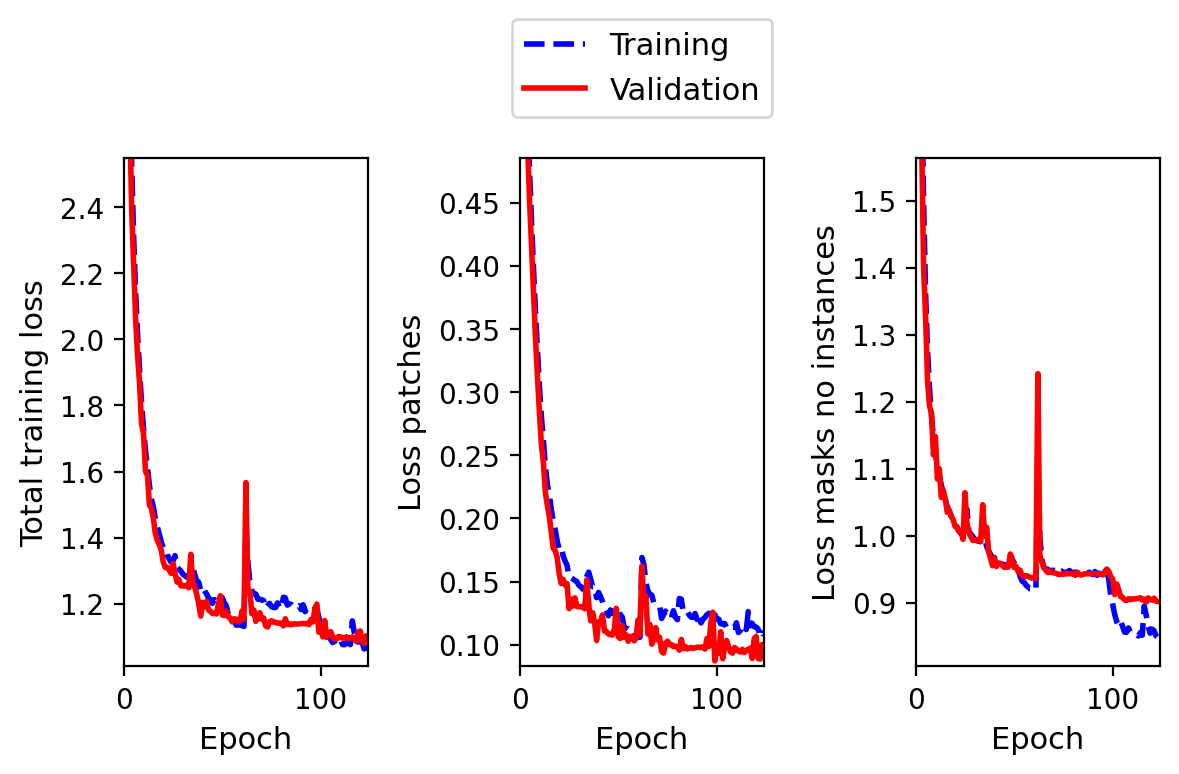

In [14]:
logs = pd.read_csv(pathlib.Path(trainer1a.logger.log_dir + "/metrics.csv"))
epochs = logs.dropna(subset=["train_loss"])["epoch"]

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(6, 4))
y1 = logs["train_loss"].dropna()
y2 = logs["val_loss"].dropna()
l1 = ax0.plot(
    epochs, y1, color="b", linewidth=2, linestyle="dashed", label="Training")
l2 = ax0.plot(epochs, y2, color="r", linewidth=2, label="Validation")
ax0.set_xlabel("Epoch", fontsize=11)
ax0.set_ylabel("Total training loss", fontsize=11)
ax0.set_xlim(0, len(epochs) - 1)
ax0.set_ylim(
    min(min(y1), min(y2)) * 0.95,
    min(min(y1),
        min(y2)) + (max(max(y1), max(y2)) - min(min(y1), min(y2))) * 0.6)

y3 = logs["train_loss_patches_masks"].dropna()
y4 = logs["val_loss_patches_masks"].dropna()
l3 = ax1.plot(
    epochs, y3, color="b", linewidth=2, linestyle="dashed", label="Training")
l4 = ax1.plot(epochs, y4, color="r", linewidth=2, label="Validation")
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Loss patches", fontsize=11)
ax1.set_xlim(0, len(epochs) - 1)
ax1.set_ylim(
    min(min(y3), min(y4)) * 0.95,
    min(min(y3),
        min(y4)) + (max(max(y3), max(y4)) - min(min(y3), min(y4))) * 0.6)
ax1.legend(l3+l4, [l.get_label() for l in l3+l4], loc="lower center",
           bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=1, fontsize=11)

y5 = logs["train_loss_masks"].dropna()
y6 = logs["val_loss_masks"].dropna()
l5 = ax2.plot(
    epochs, y5, color="b", linewidth=2, linestyle="dashed", label="Training")
l6 = ax2.plot(epochs, y6, color="r", linewidth=2, label="Validation")
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Loss masks no instances", fontsize=11)
ax2.set_xlim(0, len(epochs) - 1)
ax2.set_ylim(
    min(min(y5), min(y6)) * 0.95,
    min(min(y5),
        min(y6)) + (max(max(y5), max(y6)) - min(min(y5), min(y6))) * 0.6)
plt.tight_layout()
plt.show()

In [15]:
checkpoint_file = trainer1a.checkpoint_callback.best_model_path

model001 = PatchPerPixModule.load_from_checkpoint(
    checkpoint_file, contractions_masks=contractions_masks,
    filter_init_masks=filter_init_masks,
    contractions_patches=contractions_patches,
    filter_init_patches=filter_init_patches, input_shape=resized_shape,
    codes=codes, patch_size=patch_size,
    loss_masks=loss_masks, loss_patches_masks=loss_patches_masks,
    loss_weights=loss_weights, stride=stride,
    f_hidden_size_conditional=f_hidden_size_conditional)

model001 = model001.patch_per_pix
_ = model001.eval()
torch.save(model001, "./drive/MyDrive/model006.pt")

In [16]:
device = "cpu"
model001 = torch.load("./drive/MyDrive/model006.pt", map_location="cpu")
_ = model001.eval()

Let's look at an examplary predicted mask of the trained model on an image from the test set:

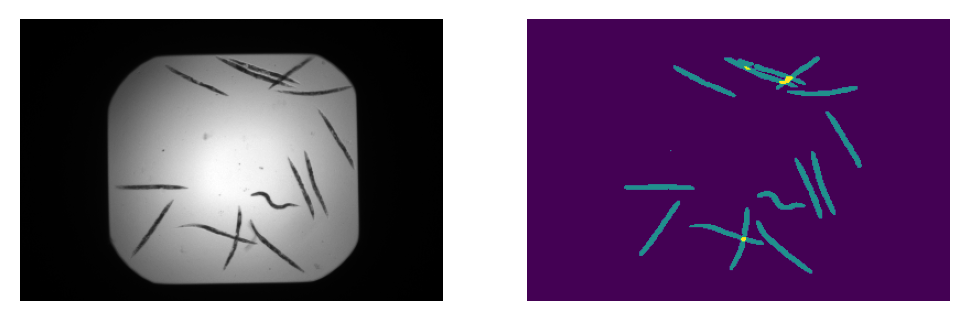

In [17]:
def infer_model(model, fp_img, fp_annotations, resized_shape):
    img, mask_instances, mask_semantic = retreive_img_and_annotations(
        fp_img, fp_annotations)
    transform = A.Compose([A.Resize(resized_shape[1], resized_shape[2])],
                      additional_targets={"mask1": "mask", "mask2": "mask"})
    transformed = transform(
        image=img, mask1=mask_instances, mask2=mask_semantic)
    img = transformed["image"]
    mask_instances = transformed["mask1"]
    mask_semantic = transformed["mask2"]

    img = np.expand_dims(np.moveaxis(img, 2, 0), 0).astype(np.float32)
    mask_no_instances, patches_masks = model(torch.tensor(img).to(device))
    mask_no_instances = mask_no_instances.detach().cpu().numpy()[0]
    patches_masks = [x.detach().cpu().numpy() for x in patches_masks][0]
    return img, mask_instances, mask_no_instances, patches_masks


idx = 19
img1, mask_instances1_true, mask_no_instances1_pred, patches_masks1_pred = infer_model(
    model001, fp_imgs_test[idx], fp_annotations, resized_shape)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(np.moveaxis(img1[0], 0, 2), cmap="gray")
ax[1].imshow(np.argmax(mask_no_instances1_pred, axis=0))
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

And also have a look at an extract of the predicted patches for above image:

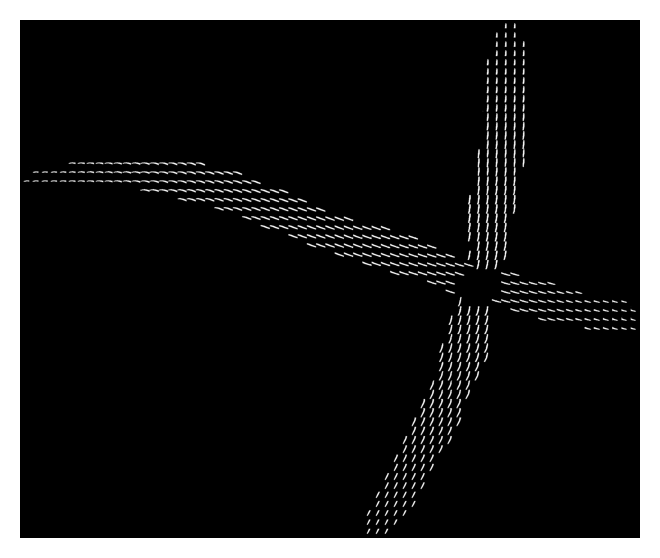

In [18]:
def extract_agg_coords(mask_fg, min_area):
    no_agglomerations, mask_labeled, stats, _ = cv2.connectedComponentsWithStats(
        mask_fg.astype("uint8"))
    to_remove = np.where(stats[:, 4] < min_area)[0].tolist()

    coords_agg = []
    for idx in range(no_agglomerations):
        coords_agg.append(np.stack(np.where(mask_labeled == idx), axis=-1))
    coords_agg = [x for idx, x in enumerate(coords_agg) if idx not in to_remove]
    return coords_agg[1:]


def extract_aggs(mask_no_instances, patches_mask, stride, min_area):
    mask_fg = (
        (np.argmax(mask_no_instances, axis=0) == 1) |
        (np.argmax(mask_no_instances, axis=0) == 2)).astype(bool)
    coords_fg_aggs = extract_agg_coords(mask_fg, min_area)

    mask_class1 = (np.argmax(mask_no_instances, axis=0) == 1)
    coords_class1_x, coords_class1_y = np.where(mask_class1)
    coords_class1_x, coords_class1_y = downsample(
        coords_class1_x, coords_class1_y, stride)
    coords_class1 = np.stack((coords_class1_x, coords_class1_y), axis=-1)

    coords_class1_aggs = []
    coords_patches_aggs = []
    patches_aggs = []

    masks_fg = np.zeros((len(coords_fg_aggs), mask_no_instances.shape[1],
                         mask_no_instances.shape[2]), dtype=bool)

    for idx_agg, coords_fg_agg in enumerate(coords_fg_aggs):
        masks_fg[idx_agg, coords_fg_agg[:, 0], coords_fg_agg[:, 1]] = True
        coords_class1_agg = coords_fg_agg[np.where(
            (coords_fg_agg == coords_class1[:, None]).all(-1))[1], :]
        coords_class1_aggs.append(coords_class1_agg)

        idx = np.where((coords_class1 == coords_class1_agg[:, None]).all(-1))[1]
        coords_patches_agg = np.stack((downsample(
            coords_class1_agg[:, 0], coords_class1_agg[:, 1], stride)), axis=-1)
        coords_patches_aggs.append(coords_patches_agg)
        patches_aggs.append(patches_mask[idx])
    return masks_fg, coords_class1_aggs, coords_patches_aggs, patches_aggs


(masks_fg1_agg_pred, coords1_aggs_pred, coords_patches1_aggs_pred,
    patches1_aggs_pred) = extract_aggs(
        mask_no_instances1_pred, patches_masks1_pred,
        stride, min_area=min_agg_area)

idx = 9
mask_no_instances1_agg9 = np.zeros((3, resized_shape[1], resized_shape[2]))
mask_no_instances1_agg9[1, coords1_aggs_pred[idx][:, 0],
                        coords1_aggs_pred[idx][:, 1]] = 1

x_lim = [np.min(coords1_aggs_pred[idx][:, 0]) / resized_shape[1],
         np.max(coords1_aggs_pred[idx][:, 0]) / resized_shape[1]]
y_lim = [np.min(coords1_aggs_pred[idx][:, 1]) / resized_shape[2],
         np.max(coords1_aggs_pred[idx][:, 1]) / resized_shape[2]]

display_img_of_patches(
    mask_no_instances1_agg9, patches1_aggs_pred[idx], stride, x_lim, y_lim)

For assembling the instances I do not use the approach laid out in the PatchPerPix paper, but a simpler modification of the approach described by Liu et al.:
- [Liu et al. Multi-scale Patch Aggregation (MPA) for Simultaneous Detection and Segmentation. **2016**](https://openaccess.thecvf.com/content_cvpr_2016/papers/Liu_Multi-Scale_Patch_Aggregation_CVPR_2016_paper.pdf)

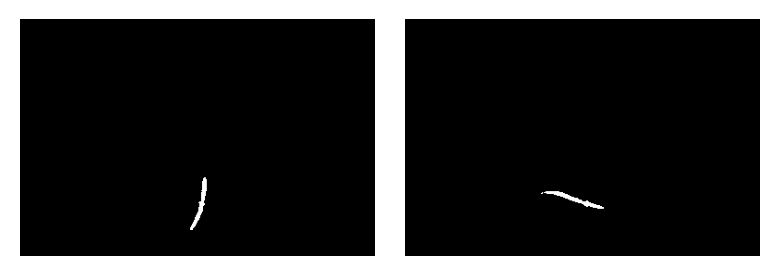

In [19]:
def find_candidates(coords, patch_size, affinity_zone):
    # affinity_zone: doing a center crop of affinity_zone % of the patch size
    cut_off = math.floor(patch_size / 2) * affinity_zone
    combs = np.stack(np.triu_indices(coords.shape[0], 1), axis=1)
    coords_src = coords[combs[:, 0], :]
    coords_dst = coords[combs[:, 1], :]
    distances = np.sum(np.abs(coords_src - coords_dst), axis=-1) # manhattan
    return combs[distances <= cut_off]


def get_bboxes(coords, patch_size):
    bboxes = np.zeros((coords.shape[0], 4), dtype=np.int32)
    bboxes[:, 0] = coords[:, 0] - math.floor(patch_size / 2) # x_min
    bboxes[:, 1] = coords[:, 0] + math.ceil(patch_size / 2) # x_max
    bboxes[:, 2] = coords[:, 1] - math.floor(patch_size / 2) # y_min
    bboxes[:, 3] = coords[:, 1] + math.ceil(patch_size / 2) # y_max
    return bboxes


def calc_affinities(patches, combs, bboxes, patch_size, probs_threshold):
    affinities = np.zeros((combs.shape[0], 1), dtype=np.float32)
    for idx in range(combs.shape[0]):
        idx_src = combs[idx, 0]
        idx_dst = combs[idx, 1]
        bbox_src = bboxes[idx_src]
        bbox_dst = bboxes[idx_dst]
        bbox_intersection = np.array([
            max(bbox_src[0], bbox_dst[0]), min(bbox_src[1], bbox_dst[1]),
            max(bbox_src[2], bbox_dst[2]), min(bbox_src[3], bbox_dst[3])])
        patch_src = patches[
            idx_src, 0,
            (bbox_intersection[0] - bbox_src[0]):(
                patch_size - abs(bbox_intersection[1] - bbox_src[1])),
            (bbox_intersection[2] - bbox_src[2]):(
                patch_size - abs(bbox_intersection[3] - bbox_src[3]))]
        patch_dst = patches[
            idx_dst, 0,
            (bbox_intersection[0] - bbox_dst[0]):(
                patch_size - abs(bbox_intersection[1] - bbox_dst[1])),
            (bbox_intersection[2] - bbox_dst[2]):(
                patch_size - abs(bbox_intersection[3] - bbox_dst[3]))]
        affinity = (
            (np.sum((patch_src > probs_threshold) * (patch_dst > probs_threshold)) -
             np.sum((patch_src < probs_threshold) * (patch_dst > probs_threshold)) -
             np.sum((patch_src > probs_threshold) * (patch_dst < probs_threshold))) /
              (patch_src.shape[0] * patch_src.shape[1]))
        affinities[idx, 0] = affinity

    affinities = np.hstack((combs, affinities))
    return affinities


def filter_affinities(affinities, affinity_threshold1, affinity_threshold2):
    shape = np.unique(affinities[:, 0:2]).shape[0]
    affinity_matrix = np.zeros((shape, shape))
    affinity_matrix[affinities[:, 0].astype(np.int32),
                    affinities[:, 1].astype(np.int32)] = affinities[:, 2]
    affinity_matrix[affinities[:, 1].astype(np.int32),
                    affinities[:, 0].astype(np.int32)] = affinities[:, 2]
    idx_to_remove = np.where(
        np.mean(affinity_matrix, axis=-1,
                where=(affinity_matrix != 0)) < affinity_threshold1)
    affinities = affinities[~np.any(np.isin(affinities[:, 0:2], idx_to_remove), axis=-1)]
    affinities = affinities[affinities[:, 2] > affinity_threshold2]
    idx_sort = np.argsort(affinities[:, 2])[::-1]
    return affinities[idx_sort]


def update_instances_list(element1, element2, instances):
    idx_element1, idx_element2 = None, None

    for idx, instance in enumerate(instances):
        if element1 in instance:
            idx_element1 = idx
        if element2 in instance:
            idx_element2 = idx

    if all(x is None for x in [idx_element1, idx_element2]):
        instances.append({element1, element2})
    elif all(x is not None for x in [idx_element1, idx_element2]):
        if idx_element1 != idx_element2:
            popped = instances.pop(max(idx_element1, idx_element2))
            [instances[min(idx_element1, idx_element2)].add(x) for x in popped]
    else:
        idx = [x for x in [idx_element1,idx_element2] if x is not None][0]
        [instances[idx].add(x) for x in [element1, element2]]
    return instances


def get_idx_of_instances(affinities):
    instances = []
    for idx in range(affinities.shape[0]):
        idx_src = affinities[idx, 0].astype(np.int32)
        idx_dst = affinities[idx, 1].astype(np.int32)
        instances = update_instances_list(idx_src, idx_dst, instances)
    return instances


def get_instance_mask(instances_idx_list, patches, coords_patches, patch_size,
                      threshold, masks_fg_aggs):
    padding = math.floor(patch_size / 2)
    masks_instances = np.zeros(
        (len(instances_idx_list), masks_fg_aggs.shape[0] + padding * 2,
         masks_fg_aggs.shape[1] + padding * 2))
    counts = np.zeros_like(masks_instances)

    for idx1, instance in enumerate(instances_idx_list):
        coords_cur = coords_patches[list(instance), :]
        patches_cur = patches[list(instance), :]
        bboxes_cur = get_bboxes(coords_cur, patch_size) + padding
        for idx2 in range(bboxes_cur.shape[0]):
            x_min, x_max, y_min, y_max = bboxes_cur[idx2]
            masks_instances[idx1, x_min:x_max, y_min:y_max] = patches_cur[idx2]
            counts[idx1, x_min:x_max, y_min:y_max] = np.ones_like(
                patches_cur[idx2], dtype=np.float32)

    masks_instances = np.divide(masks_instances, counts, out=np.zeros_like(
        counts), where=counts!=0)
    masks_instances = masks_instances[:, padding:-padding, padding:-padding]
    masks_instances = ((masks_fg_aggs * masks_instances) > threshold)
    return masks_instances


def display_masks_instances(masks_instances, no_cols):
    no_imgs = len(masks_instances)
    no_rows = math.ceil(no_imgs / no_cols)
    if no_imgs < no_cols:
        no_cols = no_imgs

    fig, ax = plt.subplots(no_rows, no_cols, figsize=(4, 4))
    for idx_img in range(no_imgs):
        if (no_rows > 1) & (no_cols > 1):
            idx_ax = (math.floor(idx_img / no_cols), idx_img % no_cols)
        else:
            idx_ax = (idx_img, )
        if no_imgs > 1:
            ax[idx_ax].imshow(masks_instances[idx_img], cmap="gray")
            [axi.set_axis_off() for axi in ax.ravel()]
        else:
            ax.imshow(masks_instances[idx_img], cmap="gray")
            ax.set_axis_off()
    plt.tight_layout()
    plt.show()


def segment_agg(coords, patches, mask_fg, patch_size, probs_threshold,
                affinity_zone, affinity_threshold1, affinity_threshold2):
    combs = find_candidates(coords, patch_size, affinity_zone=affinity_zone)
    bboxes = get_bboxes(coords, patch_size)
    affinities = calc_affinities(
        patches, combs, bboxes, patch_size, probs_threshold)
    affinities = filter_affinities(
        affinities, affinity_threshold1=affinity_threshold1,
        affinity_threshold2=affinity_threshold2)
    instances_idx_list = get_idx_of_instances(affinities)

    masks_instances = get_instance_mask(
        instances_idx_list, patches, coords, patch_size, probs_threshold,
        mask_fg)
    return masks_instances


masks_instances_agg9_pred = segment_agg(
    coords_patches1_aggs_pred[idx], patches1_aggs_pred[idx],
    masks_fg1_agg_pred[idx], patch_size, probs_threshold, affinity_zone,
    affinity_threshold1, affinity_threshold2)

display_masks_instances(masks_instances_agg9_pred, no_cols=2)

Let's see the instance assembly in action for the above used exemplary image from the test data:

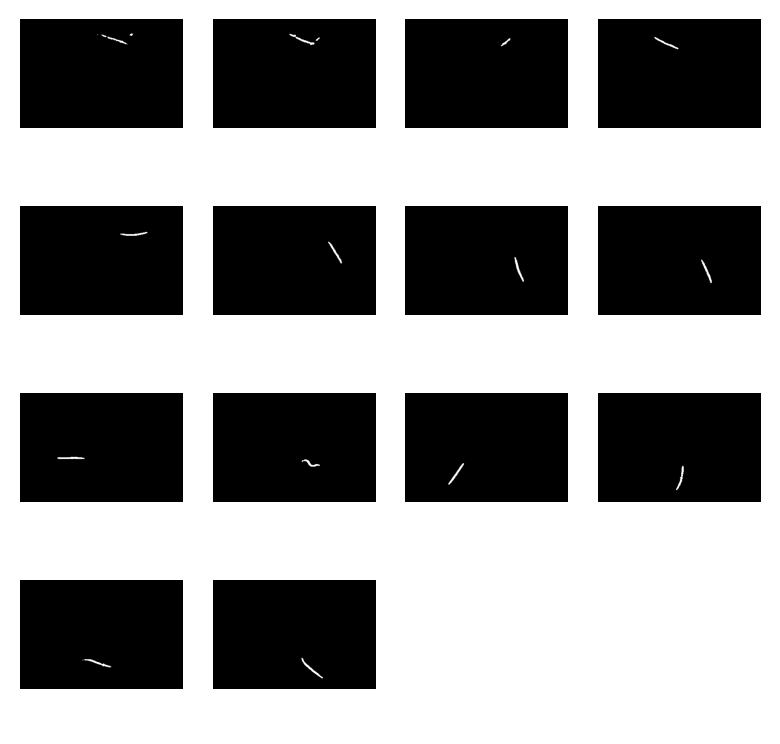

In [20]:
def segment_image(
    coords, patches, mask_fg, patch_size, probs_threshold, affinity_zone,
    affinity_threshold1, affinity_threshold2):
    masks_instances = []
    for idx in range(len(coords)):
        masks_instances.append(
            segment_agg(
                coords[idx], patches[idx], mask_fg[idx], patch_size,
                probs_threshold, affinity_zone, affinity_threshold1,
                affinity_threshold2))
    return np.concatenate(masks_instances, axis=0)


masks_instances1_pred = segment_image(
    coords_patches1_aggs_pred, patches1_aggs_pred, masks_fg1_agg_pred,
    patch_size, probs_threshold, affinity_zone, affinity_threshold1,
    affinity_threshold2)

display_masks_instances(masks_instances1_pred, no_cols=4)

Finally, let's see the complete performance across the test data. We will be calculating the sorted AP described by Chen et al., because the typically employed average precision (AP) has some weaknesses (read the paper):

- [Chen et al. SortedAP: Rethinking evaluation metrics for instance segmentation. 2023](https://arxiv.org/pdf/2309.04887.pdf)

In [21]:
e = evaluation.Evaluator(
    dimension=2, allow_overlap=True, match_method="hungarian",
    image_average=False)

scores_mAP = []
scores_sortedAP = []

for idx in range(len(fp_imgs_test)):
    e.clear()
    (img2, mask_instances2_true, mask_no_instances2_pred,
        patches_masks2_pred) = infer_model(
            model001, fp_imgs_test[idx], fp_annotations, resized_shape)
    (masks_fg2_aggs_pred, coords2_aggs_pred, coords_patches2_aggs_pred,
        patches2_aggs_pred) = extract_aggs(
            mask_no_instances2_pred, patches_masks2_pred, stride,
            min_area=min_agg_area)
    masks_instances2_pred = segment_image(
        coords_patches2_aggs_pred, patches2_aggs_pred, masks_fg2_aggs_pred,
        patch_size, probs_threshold, affinity_zone, affinity_threshold1,
        affinity_threshold2)

    e.add_example(masks_instances2_pred,
                  np.moveaxis(mask_instances2_true, 2, 0), verbose=False)
    scores_mAP.append(e.mAP(thres=[0.75], verbose=False))
    scores_sortedAP.append(e.sortedAP(verbose=False)[0])

print(f"mAP0.75: {np.mean(np.array(scores_mAP)):.3f}, sortedAP: {np.mean(np.array(scores_sortedAP)):.3f}")

mAP0.75: 0.499, sortedAP: 0.674
